# There is an increasing time trend in job openings data.

The JOLTS job opening data starts in 2000. From 2000-2023, there is a significant time trend, where job openings rate is increasing over time. In late 2023, we should understand job openings as about 0.35 percent higher, in order to compare it to rates in 2019. Currently job openings are around 5.5 percent over the past three months; in 2019 they were closer to 4.6 percent. This time trend would account for about half of the difference.

## Why does this matter?

The Federal Reserve has argued that it is focused on job openings as a condition to know that aggregate labor market activity. As Jay Powell has said, TKTKTK.

## Is this plausible?

Yes. There are two reasons to check this data for a time trend:

- Models that use job openings assume there's a cost to either maintaining job openings or executing searches based on them. Else firms could maintain an arbitrarily large amount of job openings. These costs are generally exogenous parameters in these models. It is reasonable to believe the cost has declined in recent decades given internet technology.
- Experts generally believe the period 2000- have had low levels of job openings compared to prior times.

Let's begin by loading data from FRED.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import requests
import io

fred_api_key = pd.read_csv("/Users/mkonczal/Documents/data_folder/fred_key/fred_key.csv").iloc[0,0]
fred = Fred(api_key=fred_api_key)

job_openings = fred.get_series('JTSJOR').to_frame(name='job_openings').reset_index(names="date")
unrate = fred.get_series('UNRATE').to_frame(name='unrate').reset_index(names="date")
quits = fred.get_series("JTSQUR").to_frame(name='quits').reset_index(names="date")

fred_data = pd.merge(left=job_openings, right=unrate, on="date", how="inner")
fred_data = pd.merge(left=fred_data, right=quits, on="date", how="inner")


fred_data['v_u'] = fred_data['job_openings']/fred_data['unrate']
fred_data['v_u_2'] = fred_data['v_u'] ** 2

We start by running a regression on job openings controlling for the unemployment rate and the quits rate. We then plot the residuals.

                            OLS Regression Results                            
Dep. Variable:           job_openings   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     499.1
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           2.02e-91
Time:                        22:42:42   Log-Likelihood:                -244.61
No. Observations:                 273   AIC:                             495.2
Df Residuals:                     270   BIC:                             506.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.3888      0.468    -11.524      0.0

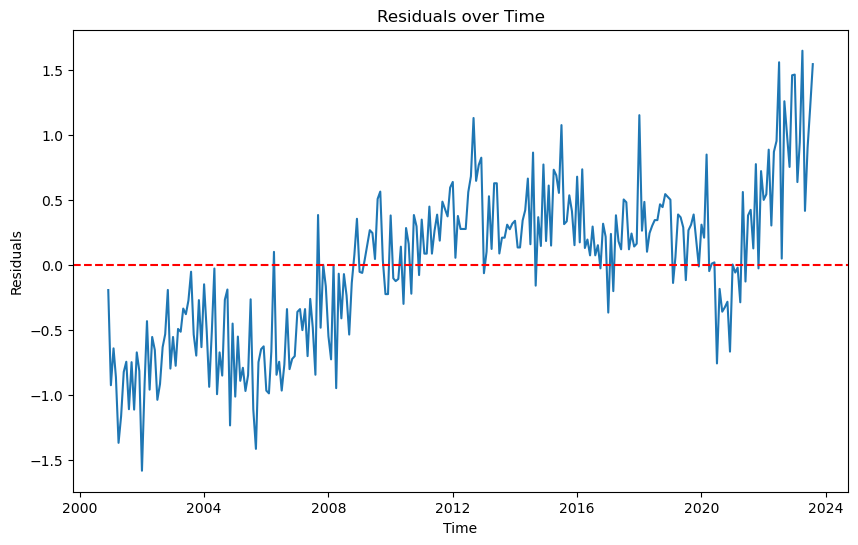

In [2]:
X = fred_data[["unrate", "quits"]]
X = sm.add_constant(X)
y = fred_data["job_openings"]


model = sm.OLS(y, X,missing='drop').fit()

print(model.summary())

# Get the residuals
residuals = model.resid

# Create a plot
plt.figure(figsize=(10,6))
plt.plot(fred_data["date"], residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Let's run that again, this time including a time variable.

                            OLS Regression Results                            
Dep. Variable:           job_openings   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1448.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):          1.23e-165
Time:                        22:42:42   Log-Likelihood:                -67.815
No. Observations:                 273   AIC:                             143.6
Df Residuals:                     269   BIC:                             158.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0645      0.260    -11.780      0.0

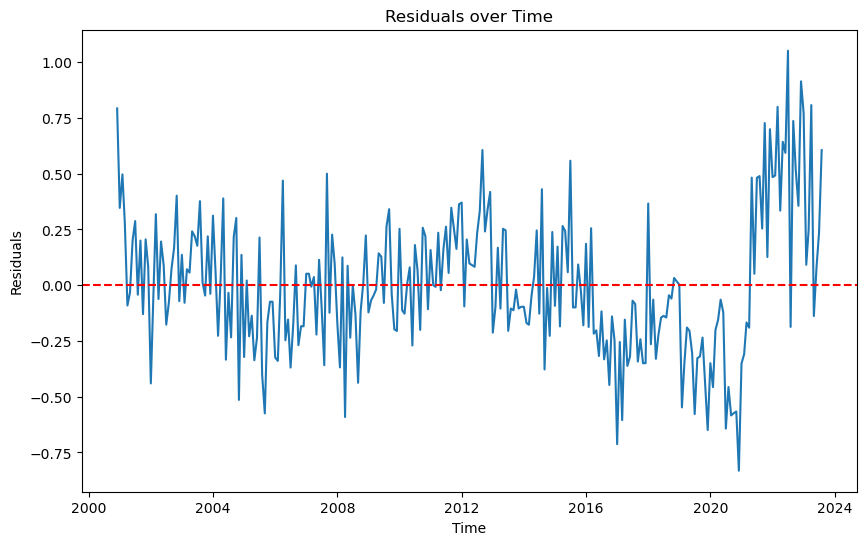

In [3]:
X2 = fred_data[["unrate", "quits"]].reset_index(names="time_index")
X2 = sm.add_constant(X2)
y2 = fred_data["job_openings"]

model2 = sm.OLS(y2, X2, missing='drop').fit()

print(model2.summary())

# Get the residuals
residuals = model2.resid

# Create a plot
plt.figure(figsize=(10,6))
plt.plot(fred_data["date"], residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Here we can see that the time index is both significant and the residuals over time are much more centered around zero. There is still a spike in recent years, TK.

Let's run a wide range of regressions that could predict changes in job openings over time, and check them if a time series value is statistically significant:

In [4]:
model3 = sm.OLS(fred_data["job_openings"], X2, missing='drop').fit()

stargazer = Stargazer([model, model2, model3])

HTML(stargazer.render_html())

## Time Trend Across 50 States

There are only so many values given we only have access to JOLTS data starting in 2000. However, we can take state-level variation and see if we see the same pattern. First, let's load the JOLTS flat files from the BEA website:

In [5]:
# Set user agent for requests
user_agent = {"User-Agent": "rortybomb@gmail.com"}

# URLs for the data
urls = {
    'jolts_data': "https://download.bls.gov/pub/time.series/jt/jt.data.1.AllItems",
    'series': "https://download.bls.gov/pub/time.series/jt/jt.series",
    'Jindustry': "https://download.bls.gov/pub/time.series/jt/jt.industry",
    'Jsizecode': "https://download.bls.gov/pub/time.series/jt/jt.sizeclass",
    'data_element': "https://download.bls.gov/pub/time.series/jt/jt.dataelement",
    'Jstate': "https://download.bls.gov/pub/time.series/jt/jt.state"
}

# Function to fetch and load data
def fetch_data(url, user_agent):
    response = requests.get(url, headers=user_agent)
    if response.status_code == 200:
        return pd.read_csv(io.StringIO(response.content.decode('utf-8')), sep="\t")
    else:
        print(f"Failed to fetch data from {url}: {response.status_code}")
        return pd.DataFrame()

# Fetch and load all data
data = {}
for key, url in urls.items():
    print(f"Fetching data for {key} from {url}")  # Debugging print statement
    try:
        data[key] = fetch_data(url, user_agent)
    except Exception as e:
        print(f"An error occurred fetching data for {key}: {str(e)}")


# Data cleanup and transformations

# jolts_data
data['jolts_data'].columns = data['jolts_data'].columns.str.lower().str.replace(' ', '')
data['jolts_data']['value'] = pd.to_numeric(data['jolts_data']['value'], errors='coerce')
data['jolts_data']['series_id'] = data['jolts_data']['series_id'].str.strip()
#data['jolts_data']['date'] = pd.to_datetime(data['jolts_data']['year'].astype(str) + 
#                                             data['jolts_data']['period'].str[1:], 
#                                             format="%Y%m")

# Other data
for key in ['series', 'Jindustry', 'Jsizecode', 'data_element', 'Jstate']:
    data[key].columns = data[key].columns.str.lower().str.replace(' ', '')
    if 'series_id' in data[key].columns:
        data[key]['series_id'] = data[key]['series_id'].str.strip()

# Merge all data together
jolts = (
    data['jolts_data']
    .merge(data['series'], on='series_id', how='inner')
    .merge(data['data_element'], on='dataelement_code', how='inner', suffixes=('.series', '.data_element'))
    .merge(data['Jindustry'], on='industry_code', how='inner', suffixes=('.x', '.industry_code'))
    .merge(data['Jsizecode'], on='sizeclass_code', how='inner')
    .merge(data['Jstate'], on='state_code', how='inner')
)

# Add dates.
# Note annual values have period "M13" and can't be translated to a date. With errors='coerce'
# we set it to NaT as a value.
jolts['date'] = pd.to_datetime(jolts['year'].astype(str) + 
                                             jolts['period'].str[1:], 
                                             format="%Y%m",
                                             errors='coerce')


Fetching data for jolts_data from https://download.bls.gov/pub/time.series/jt/jt.data.1.AllItems
Fetching data for series from https://download.bls.gov/pub/time.series/jt/jt.series
Fetching data for Jindustry from https://download.bls.gov/pub/time.series/jt/jt.industry
Fetching data for Jsizecode from https://download.bls.gov/pub/time.series/jt/jt.sizeclass
Fetching data for data_element from https://download.bls.gov/pub/time.series/jt/jt.dataelement
Fetching data for Jstate from https://download.bls.gov/pub/time.series/jt/jt.state


In [6]:
jolts = jolts[jolts['state_text'] != 'Total US']
jolts = jolts.dropna(subset=['date'])
jolts = jolts[~jolts['state_code'].isin(['MW', 'NE', 'SO', 'WE'])]

jolts = jolts[
    ((jolts['dataelement_code'] == 'JO') | (jolts['dataelement_code'] == 'QU')) &
    (jolts['ratelevel_code'] == 'R') & 
    (jolts['seasonal'] == 'S')
]

jolts = jolts[['date', 'state_text', 'dataelement_text', 'value']]

jolts_time_trend = jolts.pivot_table(
    index=['date', 'state_text'], 
    columns='dataelement_text', 
    values='value', 
    aggfunc=np.sum  # You can change the aggregation function as needed
).reset_index()

jolts_time_trend = jolts_time_trend.rename(columns={'Job openings': 'job_openings'})


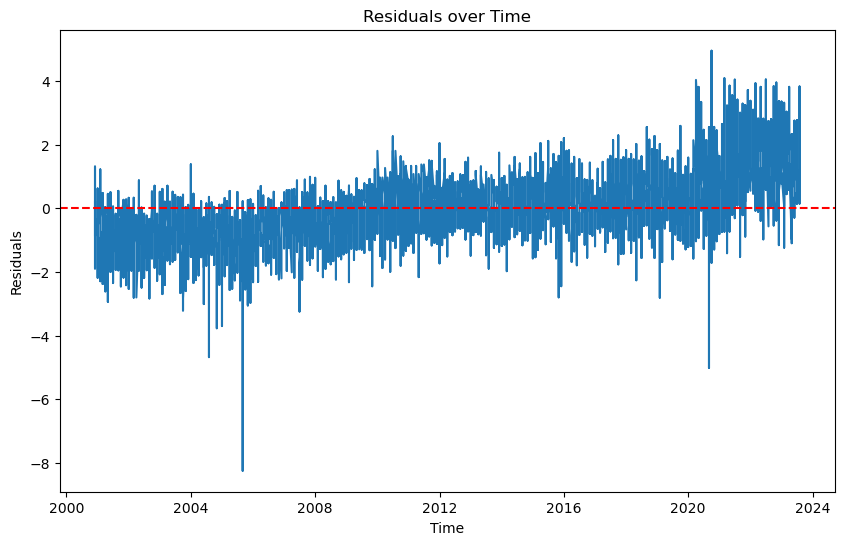

In [7]:
X2 = jolts_time_trend[["Quits"]]
X2 = sm.add_constant(X2)
y2 = jolts_time_trend["job_openings"]
X = pd.get_dummies(data=jolts_time_trend["state_text"], drop_first=True)
X2 = pd.concat([X2, X], axis=1)

model2 = sm.OLS(y2, X2, missing='drop').fit()
# Get the residuals
residuals = model2.resid

# Create a plot
plt.figure(figsize=(10,6))
plt.plot(jolts_time_trend["date"], residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


Running it again, this time including a time trend.

In [8]:
X = pd.get_dummies(data=jolts_time_trend["state_text"], drop_first=True)
X2 = jolts_time_trend[["Quits"]].reset_index(names="time_index")
X2 = sm.add_constant(X2)
X2 = pd.concat([X2, X], axis=1)
y2 = jolts_time_trend["job_openings"]

model2 = sm.OLS(y2, X2, missing='drop').fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           job_openings   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     1173.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:42:47   Log-Likelihood:                -12711.
No. Observations:               13923   AIC:                         2.553e+04
Df Residuals:                   13870   BIC:                         2.593e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.1280 

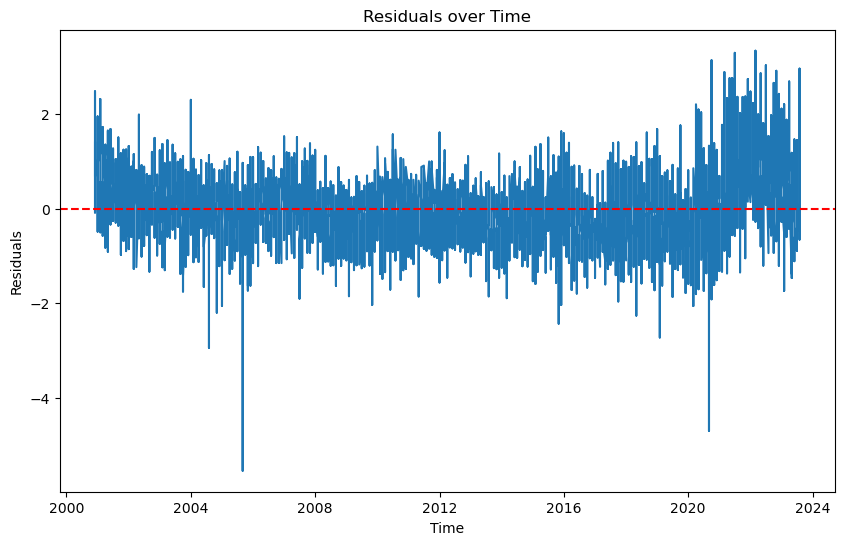

In [9]:

# Get the residuals
residuals = model2.resid

# Create a plot
plt.figure(figsize=(10,6))
plt.plot(jolts_time_trend["date"], residuals)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


As we can see here, the time variable smooths the residual across time.

### Time Series Methods Checks

We run an augmented Dickey-Fuller test TKTKTKKTK